In [289]:
import sys
import os
import os.path
import io
import csv
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# plt.rcParams.update({'font.size': 16})
import pandas as pd
from scipy.stats import gamma

# Generation of SBATCH files

Batch file creation function :

In [290]:
def batchwriter(pathtofile="analyses/scaling_param/",files_name="simul", time=24, nodes=1, ntaskspernode=1, mem=2, partition="normal", params_names=[], params_values=[],pathtoexe="../../meiosis"):
        if os.path.exists(pathtofile)==False:
            os.makedirs(pathtofile)
        batchfile= open("{0}Run_{1}.sh".format(pathtofile,files_name),"w+")
        batchfile.write("#!/bin/bash\n")
        batchfile.write("#SBATCH --partition={0}\n".format(partition))
        batchfile.write("#SBATCH --time={0}:00:00\n".format(time))
        batchfile.write("#SBATCH --nodes={0}\n".format(nodes))
        batchfile.write("#SBATCH --ntasks-per-node={0}\n".format(ntaskspernode))
        batchfile.write("#SBATCH --mem={0}gb\n".format(mem))
        batchfile.write("#SBATCH -o Run_{0}.out\n".format(files_name))
        batchfile.write("#SBATCH -e Run_{0}.err\n".format(files_name))
        batchfile.write("\n")
        batchfile.write(pathtoexe)
        for param in range(len(params_names)):
            batchfile.write(" -"+params_names[param]+" {0}".format(params_values[param]))
        batchfile.write(" Run_{0}".format(files_name))
        batchfile.close()

In [3]:
#batchwriter(files_name="V4",params_names=["u","v","w","N"],params_values=[1e-5,1e-4,1e-2,10000],pathtoexe="./meiosis")
batchwriter()

Creation of directory of batch files :

In [294]:
def scaling_U(params_list=["1e-2","1e-3","1e-4","1e-5","1e-6","1e-7","1e-8"],N=1000,nbGenerations=10000,time=24):
    index_u=1
    path="analyses/scaling_U_{0}/".format(index_u)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_u+=1
        path="analyses/scaling_U_{0}/".format(index_u)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="U_{0}".format(params_list[i]), params_names=["u","N","nbGenerations"], params_values=[float(params_list[i]),N,nbGenerations],pathtoexe="../../meiosis",time=time)

In [295]:
scaling_U(N=200,nbGenerations=100000,time=72)

True
analyses/scaling_U_2/
analyses/scaling_U_3/
analyses/scaling_U_4/
analyses/scaling_U_5/


In [296]:
def scaling_V(params_list=["1e-2","1e-3","1e-4","1e-5","1e-6","1e-7","1e-8"],N=1000,nbGenerations=10000,time=24):
    index_v=1
    path="analyses/scaling_V_{0}/".format(index_v)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_v+=1
        path="analyses/scaling_V_{0}/".format(index_v)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="V_{0}".format(params_list[i]), params_names=["v","N","nbGenerations"], params_values=[float(params_list[i]),N,nbGenerations],pathtoexe="../../meiosis",time=time)

In [297]:
scaling_V(N=200,nbGenerations=100000,time=72)

True
analyses/scaling_V_2/
analyses/scaling_V_3/
analyses/scaling_V_4/
analyses/scaling_V_5/


In [64]:
def scaling_N(params_list=["1e3","1e4","1e5","1e6"]):
    index_N=1
    path="analyses/scaling_N_{0}/".format(index_N)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_N+=1
        path="analyses/scaling_N_{0}/".format(index_N)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="N_{0}".format(params_list[i]), params_names=["N"], params_values=[float(params_list[i])],pathtoexe="../../meiosis")

In [65]:
scaling_N()

True
analyses/scaling_N_2/
analyses/scaling_N_3/
analyses/scaling_N_4/


In [299]:
def scaling_M(params_list=["1e-1","1e-2","1e-3","1e-4","1e-5","1e-6","1e-7","1e-8"], nbgenmig=4000,N=1000,time=24):
    index_m=1
    path="analyses/scaling_M_{0}/".format(index_m)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_m+=1
        path="analyses/scaling_M_{0}/".format(index_m)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="M_{0}".format(params_list[i]), params_names=["m","nbgenmig","N"], params_values=[float(params_list[i]),nbgenmig,N],pathtoexe="../../meiosis",time=time)

In [300]:
scaling_M(params_list=["1e-1","3e-1","1e-2","3e-3","1e-3","3e-4","1e-4","3e-5","1e-5","3e-6","1e-6","3e-7","1e-7","3e-8","1e-8"],time=48)

True
analyses/scaling_M_2/
analyses/scaling_M_3/
analyses/scaling_M_4/


# Interpretations

## Panmictic

Function for reading files :

In [248]:
def readfiles(pathtofile, file_name, ext_name):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                for j in range(len(lin)):
                    data[params[j]].append(float(lin[j]))
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
    return (data)

In [117]:
def readfiles_without_neutral(pathtofile, file_name, ext_name,withoutnan):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                for j in range(len(lin)):
                    if ext_name == "allele":
                        if float(lin[1]) != -3 :
                            if withoutnan == 0:
                                data[params[j]].append(float(lin[j]))
                            elif withoutnan ==1 :
                                if lin[5]!="-nan" and lin[6]!="-nan":
                                    data[params[j]].append(float(lin[j])) 
                    else :
                        data[params[j]].append(float(lin[j]))
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
    return (data)

In [39]:
a=readfiles('analyses/scaling_V_2/','Run_V_1e-4','allele')
#len(a["Generation_number"])
print(a)
#print(readfiles("simuU5","trace"))
#sorted(os.listdir('analyses/scaling_V_2/'))

{'Generation_number': [0.0, 0.0, 10.0, 10.0, 10.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 40.0, 40.0, 50.0, 50.0, 60.0, 60.0, 70.0, 70.0, 80.0, 80.0, 90.0, 90.0, 100.0, 100.0, 110.0, 110.0, 110.0, 120.0, 120.0, 130.0, 130.0, 130.0, 140.0, 140.0, 140.0, 150.0, 150.0, 150.0, 160.0, 160.0, 160.0, 170.0, 170.0, 170.0, 180.0, 180.0, 190.0, 190.0, 200.0, 200.0, 200.0, 210.0, 210.0, 210.0, 220.0, 220.0, 220.0, 220.0, 230.0, 230.0, 230.0, 230.0, 230.0, 240.0, 240.0, 240.0, 240.0, 250.0, 250.0, 260.0, 260.0, 260.0, 260.0, 270.0, 270.0, 270.0, 280.0, 280.0, 280.0, 280.0, 280.0, 290.0, 290.0, 290.0, 290.0, 300.0, 300.0, 300.0, 300.0, 310.0, 310.0, 310.0, 310.0, 310.0, 310.0, 320.0, 320.0, 320.0, 320.0, 330.0, 330.0, 330.0, 330.0, 340.0, 340.0, 340.0, 350.0, 350.0, 350.0, 350.0, 360.0, 360.0, 360.0, 360.0, 370.0, 370.0, 370.0, 380.0, 380.0, 380.0, 380.0, 390.0, 390.0, 390.0, 390.0, 400.0, 400.0, 400.0, 400.0, 410.0, 410.0, 410.0, 410.0, 420.0, 420.0, 420.0, 430.0, 430.0, 430.0, 430.0, 430.0, 440.0, 4

Function for ploting data :

In [5]:
def plot_data(target_folder_path,x_params,y_params, file_ext):
    list_files = sorted(os.listdir(target_folder_path))
    #plt.figure(1, figsize=(20,20))
    index_line=1
    #n=(len(list_files)/6)*len(params_names)
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            plt.figure(1, figsize=(20,20))
            data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1])
            #print(params)
            plt.subplot(len(list_files)/6,1,index_line)
            plt.plot(data_file[x_params], data_file[y_params],'.')
            plt.ylabel(y_params, fontsize = 12)
            plt.xlabel(x_params+"_for_run_"+(file_name.split(".")[0]).split("_")[2], fontsize = 12)
            index_line=index_line+1

### Individual : Temporal graphs

In [206]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Diversity", file_ext="trace")

In [207]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Activity", file_ext="trace")

In [208]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Fertility_rate", file_ext="trace")

In [209]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="q", file_ext="trace")

In [210]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Frequency", file_ext="allele")

In [211]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Activity",file_ext="allele")

In [212]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Age",file_ext="allele")

In [213]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="q_allele",file_ext="allele")

In [214]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Fertility_allele",file_ext="allele")

### Individual : Params vs age

In [215]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="Frequency", file_ext="allele")

In [216]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="Activity", file_ext="allele")

In [217]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="q_allele",file_ext="allele")

In [218]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="Fertility_allele",file_ext="allele")

In [101]:
def graph_per_allele(target_folder_path, file_name, ext_name, x_axis_param, y_axis_param):
    data = readfiles(target_folder_path, file_name, ext_name)
    x_per_allele=dict()
    y_per_allele=dict()
    for i in range(len(data["Generation_number"])):
        cle = data['Allele_number'][i]
        if ((str(cle) in x_per_allele) == False and cle!=-3):
            x_per_allele[str(cle)]=[]
            x_per_allele[str(cle)].append(data[x_axis_param][i])
            y_per_allele[str(cle)]=[]
            y_per_allele[str(cle)].append(data[y_axis_param][i])
        elif ((str(cle) in x_per_allele) == True and cle!=-3):
            x_per_allele[str(cle)].append(data[x_axis_param][i])
            y_per_allele[str(cle)].append(data[y_axis_param][i])
    return(x_per_allele,y_per_allele)

In [102]:
(X,Y)=graph_per_allele("analyses/scaling_V_2/", 'Run_V_1e-4', 'allele', "q_allele", "Age")

Text(0.5,0,'Age')

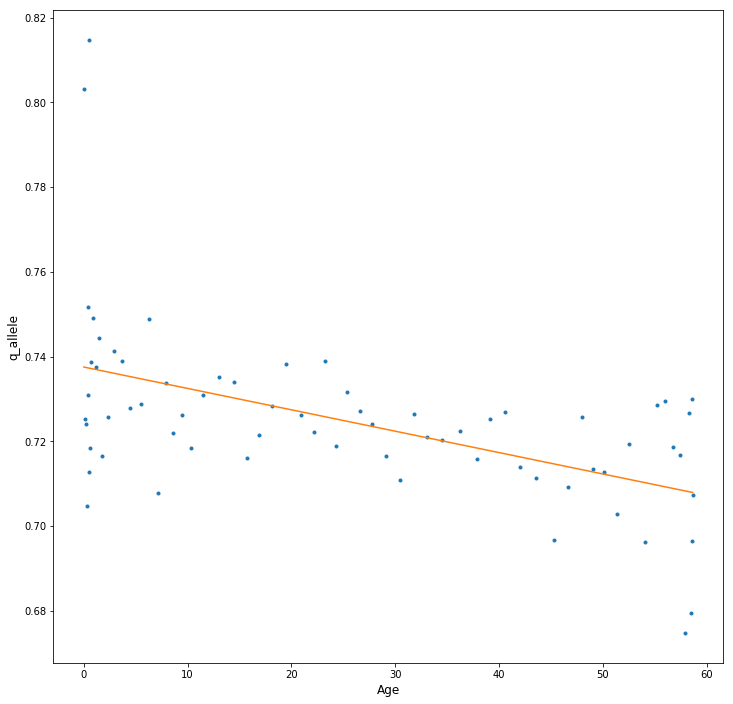

In [103]:
allele_nb = '73.0'
(X,Y)=graph_per_allele("analyses/scaling_V_2/", 'Run_V_1e-4', 'allele', "Age", "q_allele")
lm1 = LinearRegression().fit(np.array(X[allele_nb]).reshape(-1, 1), np.array(Y[allele_nb]))
plt.figure(1, figsize=(12,12))
plt.plot(X[allele_nb], Y[allele_nb], '.')
plt.plot(X[allele_nb], lm1.predict(np.array(X[allele_nb]).reshape(-1, 1)))
plt.ylabel('q_allele', fontsize = 12)
plt.xlabel('Age', fontsize = 12)

In [136]:
#print(np.array(Y[allele_nb]))
#print(lm1.predict(np.array(X[allele_nb]).reshape(-1, 1)))
score_lm1 = r2_score(np.array(Y[allele_nb]),lm1.predict(np.array(X[allele_nb]).reshape(-1, 1)))
print("R2 score : ",score_lm1)
print('intercept:', lm1.intercept_)
print('slope:', lm1.coef_)

R2 score :  -164.545823662
intercept: 0.987431740892
slope: [ -1.50516982e-05]


In [ ]:
(allele,trace)=readscalingexperiment(target_folder_path="analyses/scaling_V_2/" , scaling_param_name="V", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q"])

### Scaling

In [176]:
def readscalingexperiment(target_folder_path , scaling_param_name, param_names_allele, param_names_trace):
    list_files = sorted(os.listdir(target_folder_path))
    stat_dict_allele = dict()
    for param in param_names_allele:
        stat_dict_allele[scaling_param_name]=[]
        stat_dict_allele[param+"_mean"]=[]
        stat_dict_allele[param+"_variance"]=[]
    stat_dict_trace = dict()
    for param in param_names_trace:
        stat_dict_trace[scaling_param_name]=[]
        stat_dict_trace[param+"_mean"]=[]
        stat_dict_trace[param+"_variance"]=[]
    for file_name in list_files :
        if file_name.split(".")[1]=="allele" :
            stat_dict_allele[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1])
            for key in data_file.keys():
                (stat_dict_allele[key+"_mean"]).append(np.mean(data_file[key]))
                (stat_dict_allele[key+"_variance"]).append(np.var(data_file[key]))
        elif file_name.split(".")[1]=="trace" :
            stat_dict_trace[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1])
            for key in data_file.keys():
                (stat_dict_trace[key+"_mean"]).append(np.mean(data_file[key]))
                (stat_dict_trace[key+"_variance"]).append(np.var(data_file[key]))
    return (stat_dict_allele,stat_dict_trace)

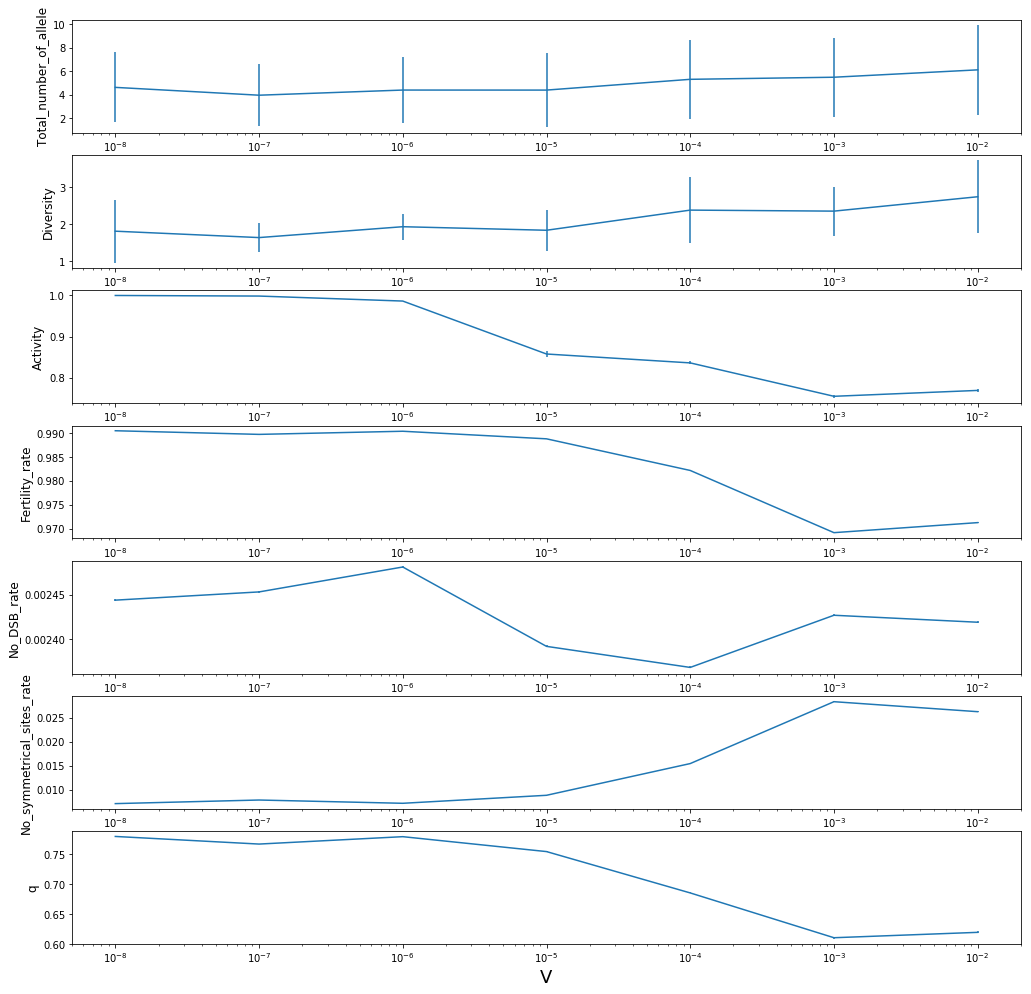

In [177]:
(allele,trace)=readscalingexperiment(target_folder_path="analyses/scaling_V_2/" , scaling_param_name="V", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q"])
scaling_param_name="V"
param_to_plot=["Total_number_of_allele","Diversity","Activity","Fertility_rate","No_DSB_rate","No_symmetrical_sites_rate","q"]
n=len(param_to_plot)

plt.figure(1, figsize=(17,17))
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    plt.errorbar(trace[scaling_param_name], trace[param_to_plot[index_parameter]+'_mean'], trace[param_to_plot[index_parameter]+'_variance'])
    plt.xscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

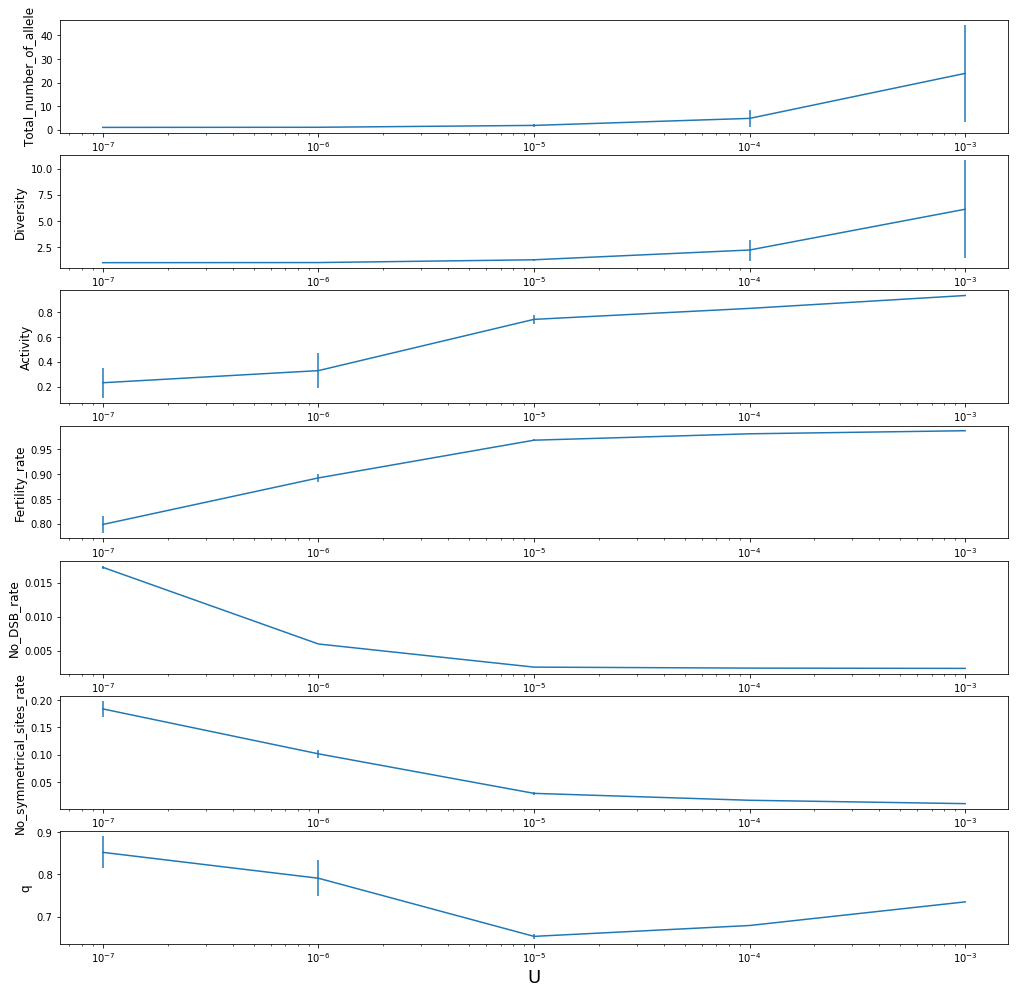

In [16]:
(allele,trace)=readscalingexperiment(target_folder_path="analyses/scaling_U_2/" , scaling_param_name="U", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q"])
scaling_param_name="U"
param_to_plot=["Total_number_of_allele","Diversity","Activity","Fertility_rate","No_DSB_rate","No_symmetrical_sites_rate","q"]
n=len(param_to_plot)

plt.figure(1, figsize=(17,17))
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    plt.errorbar(trace[scaling_param_name][1:6], trace[param_to_plot[index_parameter]+'_mean'][1:6], trace[param_to_plot[index_parameter]+'_variance'][1:6])
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

## Migration

### Individual : Temporal graphs

In [178]:
def dico_data_mig(target_folder_path,x_params,y_params, file_ext, withneutral,withoutnan):
    list_files = sorted(os.listdir(target_folder_path))
    dico_file = dict()
    dico_file_1 = dict()
    dico_file_2 = dict()
    list_namefile=[]
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            if withneutral==1:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1])
            elif withneutral==0:
                data_file=readfiles_without_neutral(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutnan)
            if (file_name.split(".")[0]).split("_")[-1] == "1" :
                dico_file_1[(file_name.split(".")[0]).split("_")[2]+"_x_params"]=data_file[x_params]
                dico_file_1[(file_name.split(".")[0]).split("_")[2]+"_y_params"]=data_file[y_params]
            if (file_name.split(".")[0]).split("_")[-1] == "2" :
                dico_file_2[(file_name.split(".")[0]).split("_")[2]+"_x_params"]=data_file[x_params]
                dico_file_2[(file_name.split(".")[0]).split("_")[2]+"_y_params"]=data_file[y_params]
            if  x_params in data_file and y_params in data_file :
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_x_params"]=data_file[x_params]
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_y_params"]=data_file[y_params]
            list_namefile.append((file_name.split(".")[0]).split("_")[2])
    list_namefile=sorted(list(set(list_namefile)))
    return (list_namefile,dico_file,dico_file_1,dico_file_2)

In [182]:
def plot_data_mig(target_folder_path,x_params,y_params, file_ext, withneutral, withoutnan):
    plt.figure(1, figsize=(20,20))
    index_line=1
    list_namefile,dico_file,dico_file_1,dico_file_2=dico_data_mig(target_folder_path,x_params,y_params, file_ext, withneutral, withoutnan)
    for i in list_namefile :
        plt.subplot(len(list_namefile),1,index_line)
        if i+"_x_params" in dico_file and i+"_y_params" in dico_file:
            plt.plot(dico_file[i+"_x_params"],dico_file[i+"_y_params"],'.',label="pop before migration")
        plt.plot(dico_file_1[i+"_x_params"],dico_file_1[i+"_y_params"],'.',label="pop1")
        plt.plot(dico_file_2[i+"_x_params"],dico_file_2[i+"_y_params"],'.',label="pop2")
        plt.ylabel(y_params, fontsize = 12)
        plt.xlabel(x_params+"_for_run_"+i, fontsize = 12)
        index_line=index_line+1

In [220]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Diversity","trace",1,0)

In [221]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Activity","trace",1,0)

In [222]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Fertility_rate","trace",1,0)

In [223]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q","trace",1,0)

In [224]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q_intra","trace",1,0)

In [226]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","fertility_intra","trace",1,0)

In [227]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q_inter","trace",1,0)

In [228]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","fertility_inter","trace",1,0)

In [229]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","FST_neutral","trace",1,0)

In [230]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","FST_PRDM9","trace",1,0)

In [231]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Frequency","allele",0,0)

In [232]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Activity","allele",0,0)

In [233]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Age","allele",0,0)

In [234]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q_allele","allele",0,0)

In [235]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Fertility_allele","allele",0,0)

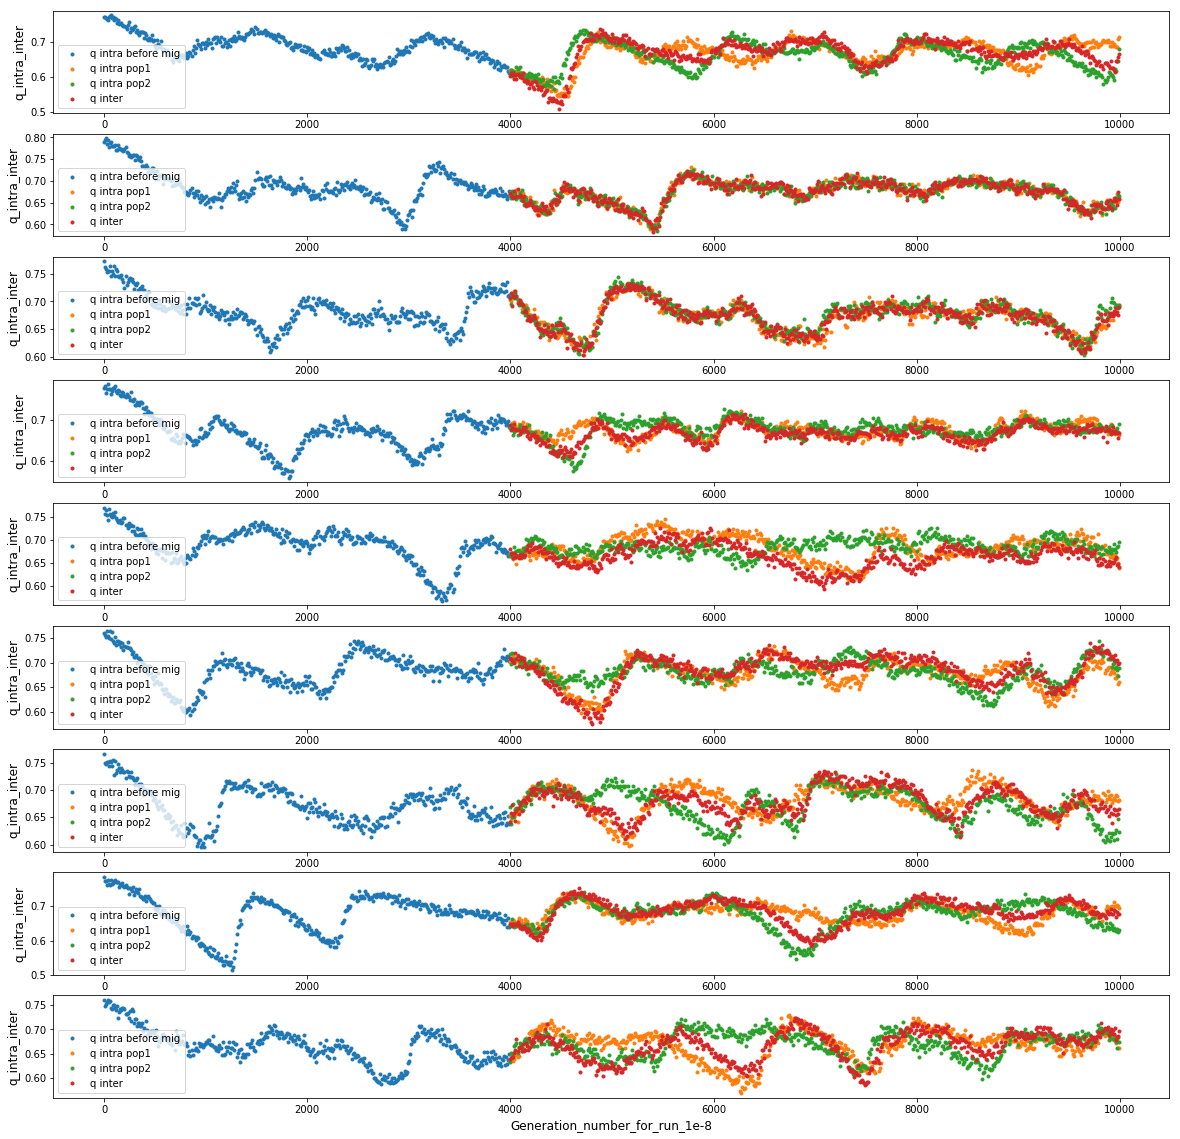

In [198]:
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file_inter,dico_file_1_inter,dico_file_2_inter=dico_data_mig("analyses/scaling_M_3/","Generation_number","q_inter", "trace",0,0)
list_namefile,dico_file_intra,dico_file_1_intra,dico_file_2_intra=dico_data_mig("analyses/scaling_M_3/","Generation_number","q_intra", "trace",0,0)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    if i+"_x_params" in dico_file_intra and i+"_y_params" in dico_file_intra:
        plt.plot(dico_file_intra[i+"_x_params"],dico_file_intra[i+"_y_params"],'.',label="q intra before mig")
    plt.plot(dico_file_1_intra[i+"_x_params"],dico_file_1_intra[i+"_y_params"],'.',label="q intra pop1")
    plt.plot(dico_file_2_intra[i+"_x_params"],dico_file_2_intra[i+"_y_params"],'.',label="q intra pop2")
    plt.plot(dico_file_1_inter[i+"_x_params"],dico_file_1_inter[i+"_y_params"],'.',label="q inter")
    plt.ylabel("q_intra_inter", fontsize = 12)
    plt.xlabel("Generation_number"+"_for_run_"+i, fontsize = 12)
    plt.legend()
    index_line=index_line+1

### Individual : Params vs age

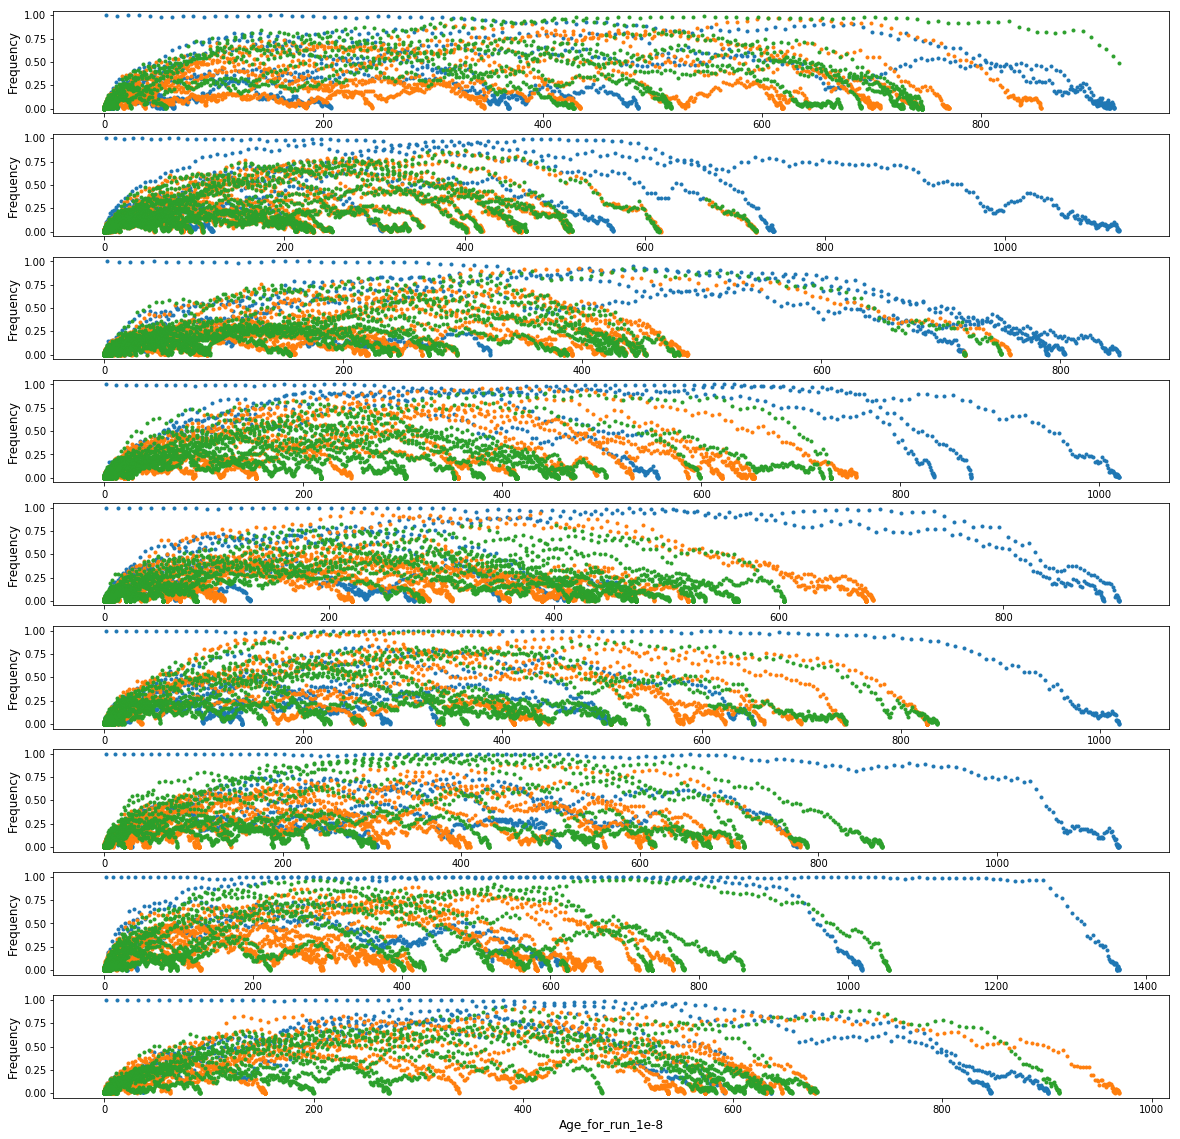

In [282]:
plot_data_mig("analyses/scaling_M_3/","Age","Frequency","allele",0,0)

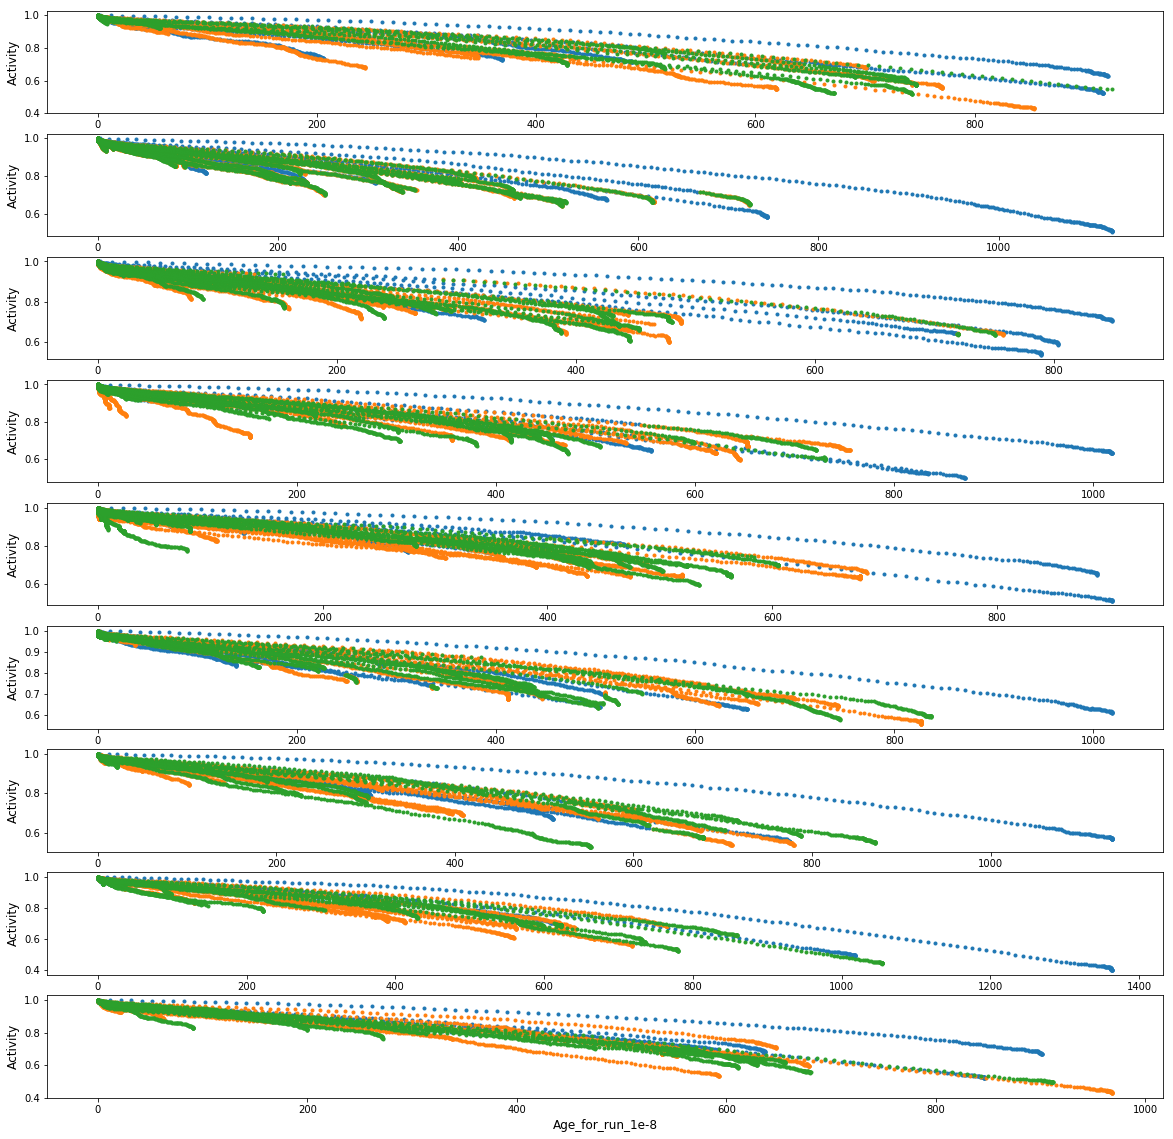

In [283]:
plot_data_mig("analyses/scaling_M_3/","Age","Activity","allele",0,0)

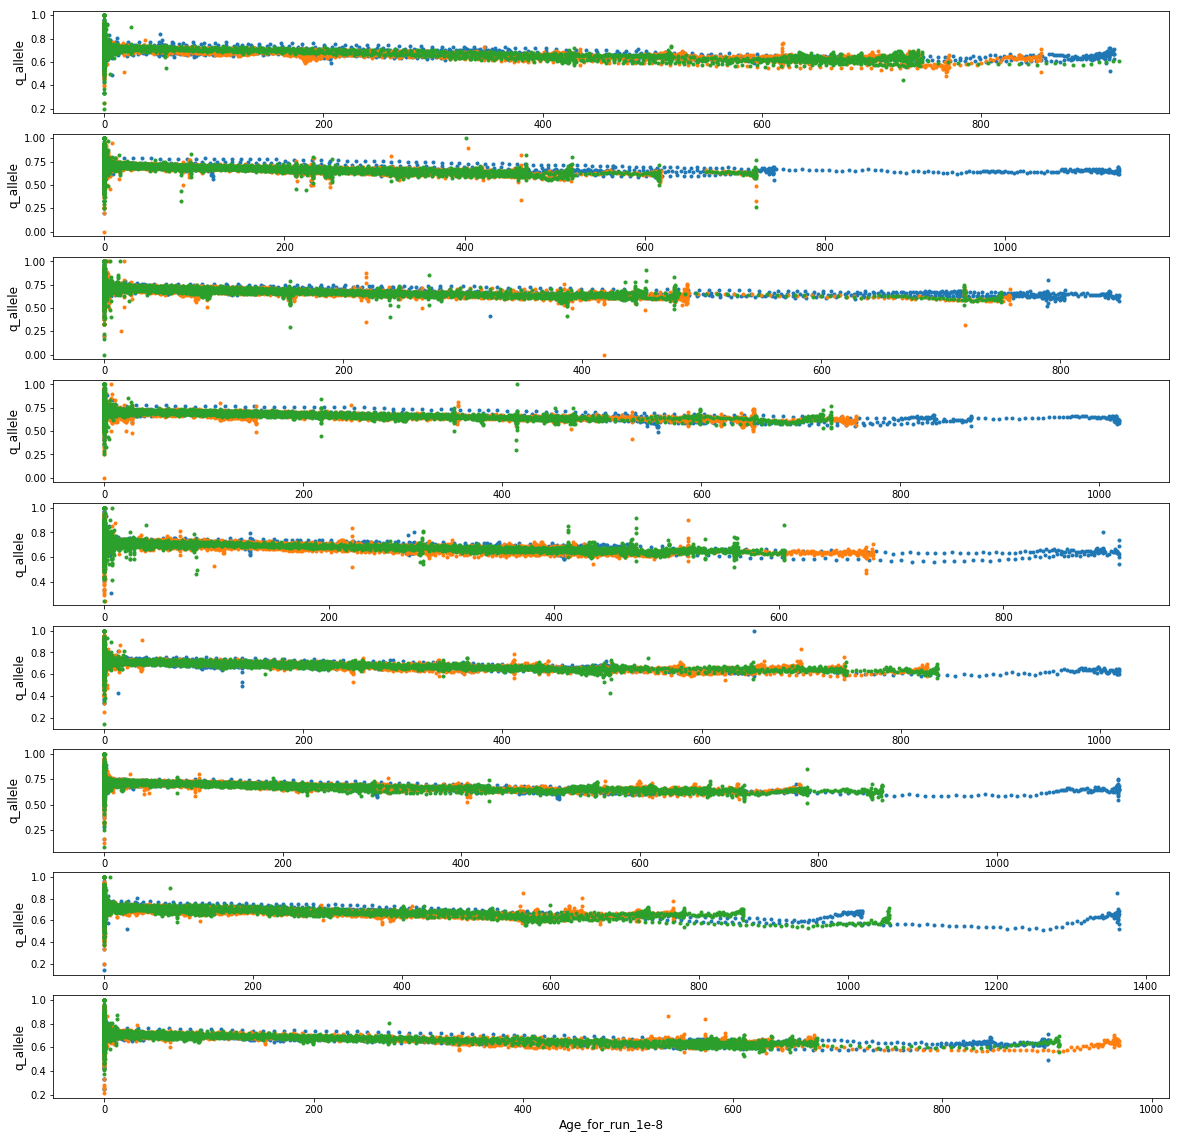

In [284]:
plot_data_mig("analyses/scaling_M_3/","Age","q_allele","allele",0,0)

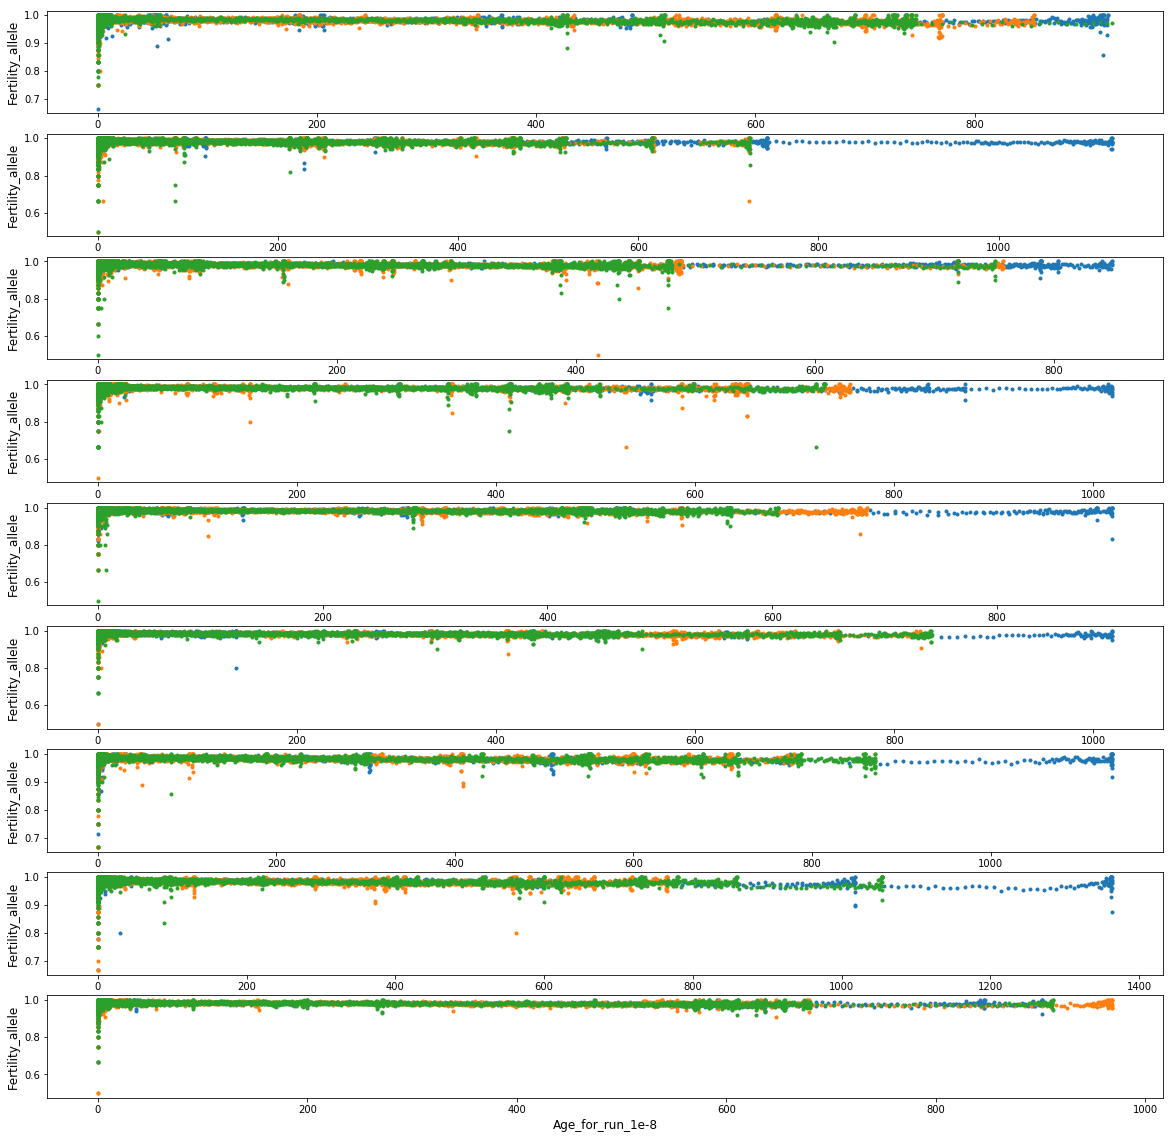

In [285]:
plot_data_mig("analyses/scaling_M_3/","Age","Fertility_allele","allele",0,0)

[array([-0.00010585]), array([ -9.18909837e-05]), array([-0.00012209]), array([-0.00012284]), array([-0.00012186]), array([-0.00012545]), array([-0.00010687]), array([-0.00010645]), array([-0.00012009])]
[array([-0.00014488]), array([-0.00020534]), array([-0.00020608]), array([-0.00015562]), array([-0.00016265]), array([-0.00012819]), array([-0.00013086]), array([-0.00013445]), array([-0.00013699])]
[array([-0.00014555]), array([-0.0001995]), array([-0.00019646]), array([-0.00017125]), array([-0.00014655]), array([-0.00013581]), array([-0.00012489]), array([-0.00012094]), array([-0.00014928])]


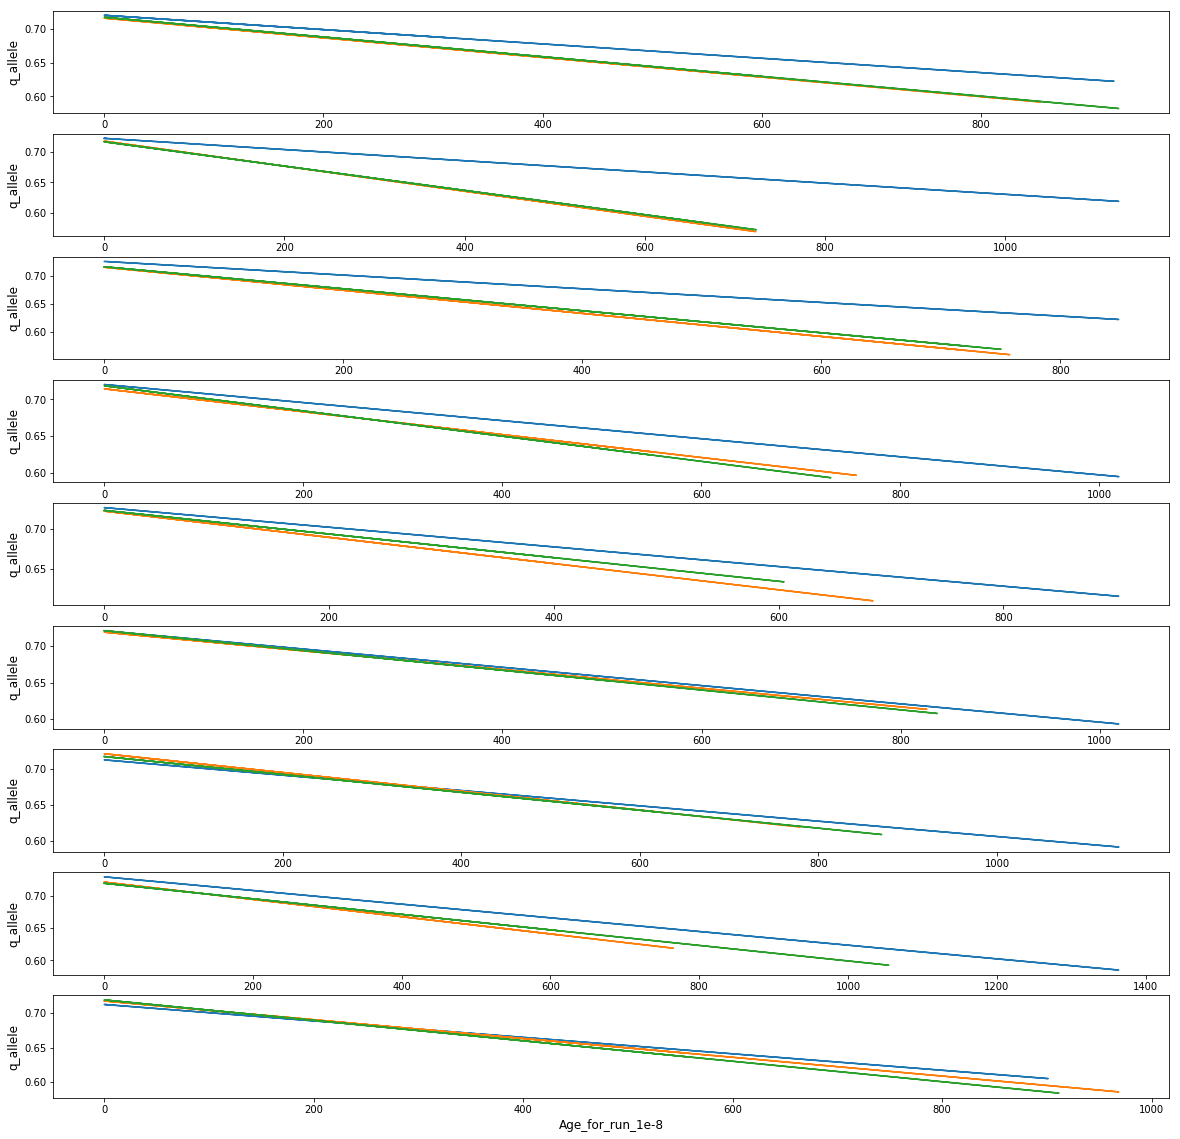

In [263]:
R2_score_list_pop=[]
R2_score_list_pop_1=[]
R2_score_list_pop_2=[]
intercept_list_pop=[]
intercept_list_pop_1=[]
intercept_list_pop_2=[]
slope_list_pop=[]
slope_list_pop_1=[]
slope_list_pop_2=[]
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file,dico_file_1,dico_file_2=dico_data_mig("analyses/scaling_M_3/","Age","q_allele","allele",0,1)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    if i+"_x_params" in dico_file and i+"_y_params" in dico_file:
        #plt.plot(dico_file[i+"_x_params"],dico_file[i+"_y_params"],'.',label="pop before migration")
        lm = LinearRegression().fit(np.array(dico_file[i+"_x_params"]).reshape(-1, 1), np.array(dico_file[i+"_y_params"]))
        plt.plot(dico_file[i+"_x_params"], lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_1[i+"_x_params"],dico_file_1[i+"_y_params"],'.',label="pop1")
    lm1 = LinearRegression().fit(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_1[i+"_y_params"]))
    plt.plot(dico_file_1[i+"_x_params"], lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_2[i+"_x_params"],dico_file_2[i+"_y_params"],'.',label="pop2")
    lm2 = LinearRegression().fit(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_2[i+"_y_params"]))
    plt.plot(dico_file_2[i+"_x_params"], lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    plt.ylabel("q_allele", fontsize = 12)
    plt.xlabel("Age"+"_for_run_"+i, fontsize = 12)
    score_lm = r2_score(np.array(dico_file[i+"_y_params"]),lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    score_lm1 = r2_score(np.array(dico_file_1[i+"_y_params"]),lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    score_lm2 = r2_score(np.array(dico_file_2[i+"_y_params"]),lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    R2_score_list_pop.append(score_lm)
    R2_score_list_pop_1.append(score_lm1)
    R2_score_list_pop_2.append(score_lm2)
    intercept_list_pop.append(lm.intercept_)
    intercept_list_pop_1.append(lm1.intercept_)
    intercept_list_pop_2.append(lm2.intercept_)
    slope_list_pop.append(lm.coef_)
    slope_list_pop_1.append(lm1.coef_)
    slope_list_pop_2.append(lm2.coef_)
    index_line=index_line+1
print(slope_list_pop)
print(slope_list_pop_1)
print(slope_list_pop_2)

[array([ -1.69238350e-05]), array([ -2.06699082e-05]), array([ -2.50977916e-05]), array([ -1.93676267e-05]), array([ -1.65647556e-05]), array([ -1.41636423e-05]), array([ -1.29564015e-05]), array([ -1.41142251e-05]), array([ -1.50516982e-05])]
[array([ -1.84432275e-05]), array([ -2.43587419e-05]), array([ -2.42771681e-05]), array([ -1.85613596e-05]), array([ -1.43364127e-05]), array([ -1.55925874e-05]), array([ -1.63812615e-05]), array([ -1.43660926e-05]), array([ -1.87492075e-05])]


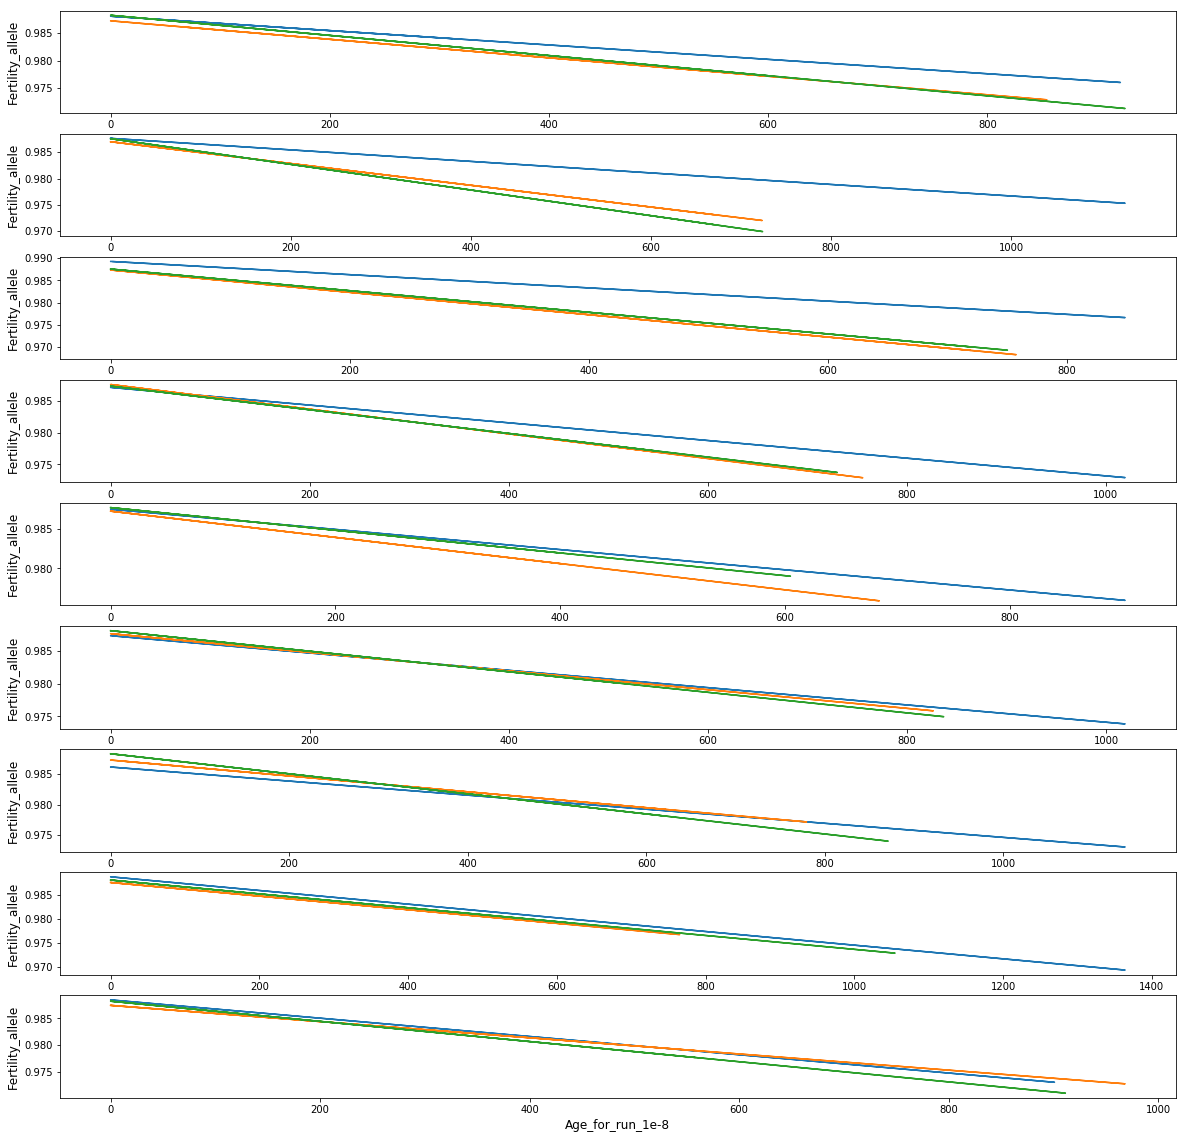

In [287]:
R2_score_list_pop=[]
R2_score_list_pop_1=[]
R2_score_list_pop_2=[]
intercept_list_pop=[]
intercept_list_pop_1=[]
intercept_list_pop_2=[]
slope_list_pop=[]
slope_list_pop_1=[]
slope_list_pop_2=[]
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file,dico_file_1,dico_file_2=dico_data_mig("analyses/scaling_M_3/","Age","Fertility_allele","allele",0,1)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    if i+"_x_params" in dico_file and i+"_y_params" in dico_file:
        #plt.plot(dico_file[i+"_x_params"],dico_file[i+"_y_params"],'.',label="pop before migration")
        lm = LinearRegression().fit(np.array(dico_file[i+"_x_params"]).reshape(-1, 1), np.array(dico_file[i+"_y_params"]))
        plt.plot(dico_file[i+"_x_params"], lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_1[i+"_x_params"],dico_file_1[i+"_y_params"],'.',label="pop1")
    lm1 = LinearRegression().fit(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_1[i+"_y_params"]))
    plt.plot(dico_file_1[i+"_x_params"], lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_2[i+"_x_params"],dico_file_2[i+"_y_params"],'.',label="pop2")
    lm2 = LinearRegression().fit(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_2[i+"_y_params"]))
    plt.plot(dico_file_2[i+"_x_params"], lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    plt.ylabel("Fertility_allele", fontsize = 12)
    plt.xlabel("Age"+"_for_run_"+i, fontsize = 12)
    score_lm = r2_score(np.array(dico_file[i+"_y_params"]),lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    score_lm1 = r2_score(np.array(dico_file_1[i+"_y_params"]),lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    score_lm2 = r2_score(np.array(dico_file_2[i+"_y_params"]),lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    R2_score_list_pop.append(score_lm)
    R2_score_list_pop_1.append(score_lm1)
    R2_score_list_pop_2.append(score_lm2)
    intercept_list_pop.append(lm.intercept_)
    intercept_list_pop_1.append(lm1.intercept_)
    intercept_list_pop_2.append(lm2.intercept_)
    slope_list_pop.append(lm.coef_)
    slope_list_pop_1.append(lm1.coef_)
    slope_list_pop_2.append(lm2.coef_)
    index_line=index_line+1
print(slope_list_pop_1)
print(slope_list_pop_2)

### Scaling

In [265]:
def readscalingexperimentmigration(target_folder_path , scaling_param_name, param_names_allele, param_names_trace):
    list_files = sorted(os.listdir(target_folder_path))
    stat_dict_allele = dict()
    stat_dict_allele_1 = dict()
    stat_dict_allele_2 = dict()
    for param in param_names_allele:
        stat_dict_allele[scaling_param_name]=[]
        stat_dict_allele[param+"_mean"]=[]
        stat_dict_allele[param+"_variance"]=[]
        stat_dict_allele_1[scaling_param_name]=[]
        stat_dict_allele_1[param+"_mean"]=[]
        stat_dict_allele_1[param+"_variance"]=[]
        stat_dict_allele_2[scaling_param_name]=[]
        stat_dict_allele_2[param+"_mean"]=[]
        stat_dict_allele_2[param+"_variance"]=[]
    stat_dict_trace = dict()
    stat_dict_trace_1 = dict()
    stat_dict_trace_2 = dict()
    for param in param_names_trace:
        stat_dict_trace[scaling_param_name]=[]
        stat_dict_trace[param+"_mean"]=[]
        stat_dict_trace[param+"_variance"]=[]
        stat_dict_trace_1[scaling_param_name]=[]
        stat_dict_trace_1[param+"_mean"]=[]
        stat_dict_trace_1[param+"_variance"]=[]
        stat_dict_trace_2[scaling_param_name]=[]
        stat_dict_trace_2[param+"_mean"]=[]
        stat_dict_trace_2[param+"_variance"]=[]
    for file_name in list_files :
        if file_name.split(".")[1]=="allele" :
            if (file_name.split(".")[0]).split("_")[-1]=="1":
                stat_dict_allele_1[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            if (file_name.split(".")[0]).split("_")[-1]=="2":
                stat_dict_allele_2[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            else:
                stat_dict_allele[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1])
            for key in data_file.keys():
                if (file_name.split(".")[0]).split("_")[-1]=="1":
                    #print(key)
                    (stat_dict_allele_1[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_allele_1[key+"_variance"]).append(np.var(data_file[key]))
                if (file_name.split(".")[0]).split("_")[-1]=="2":
                    #print(key)
                    (stat_dict_allele_2[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_allele_2[key+"_variance"]).append(np.var(data_file[key]))
                else :
                    #print(key)
                    (stat_dict_allele[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_allele[key+"_variance"]).append(np.var(data_file[key]))
        elif file_name.split(".")[1]=="trace" :
            if (file_name.split(".")[0]).split("_")[-1]=="1":
                stat_dict_trace_1[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            if (file_name.split(".")[0]).split("_")[-1]=="2":
                stat_dict_trace_2[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))  
            else :
                stat_dict_trace[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))  
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1])
            for key in data_file.keys():
                if (file_name.split(".")[0]).split("_")[-1]=="1":
                    (stat_dict_trace_1[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_trace_1[key+"_variance"]).append(np.var(data_file[key]))
                if (file_name.split(".")[0]).split("_")[-1]=="2":
                    (stat_dict_trace_2[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_trace_2[key+"_variance"]).append(np.var(data_file[key]))
                else :
                    (stat_dict_trace[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_trace[key+"_variance"]).append(np.var(data_file[key]))
    return (stat_dict_allele,stat_dict_allele_1,stat_dict_allele_2,stat_dict_trace,stat_dict_trace_1,stat_dict_trace_2)

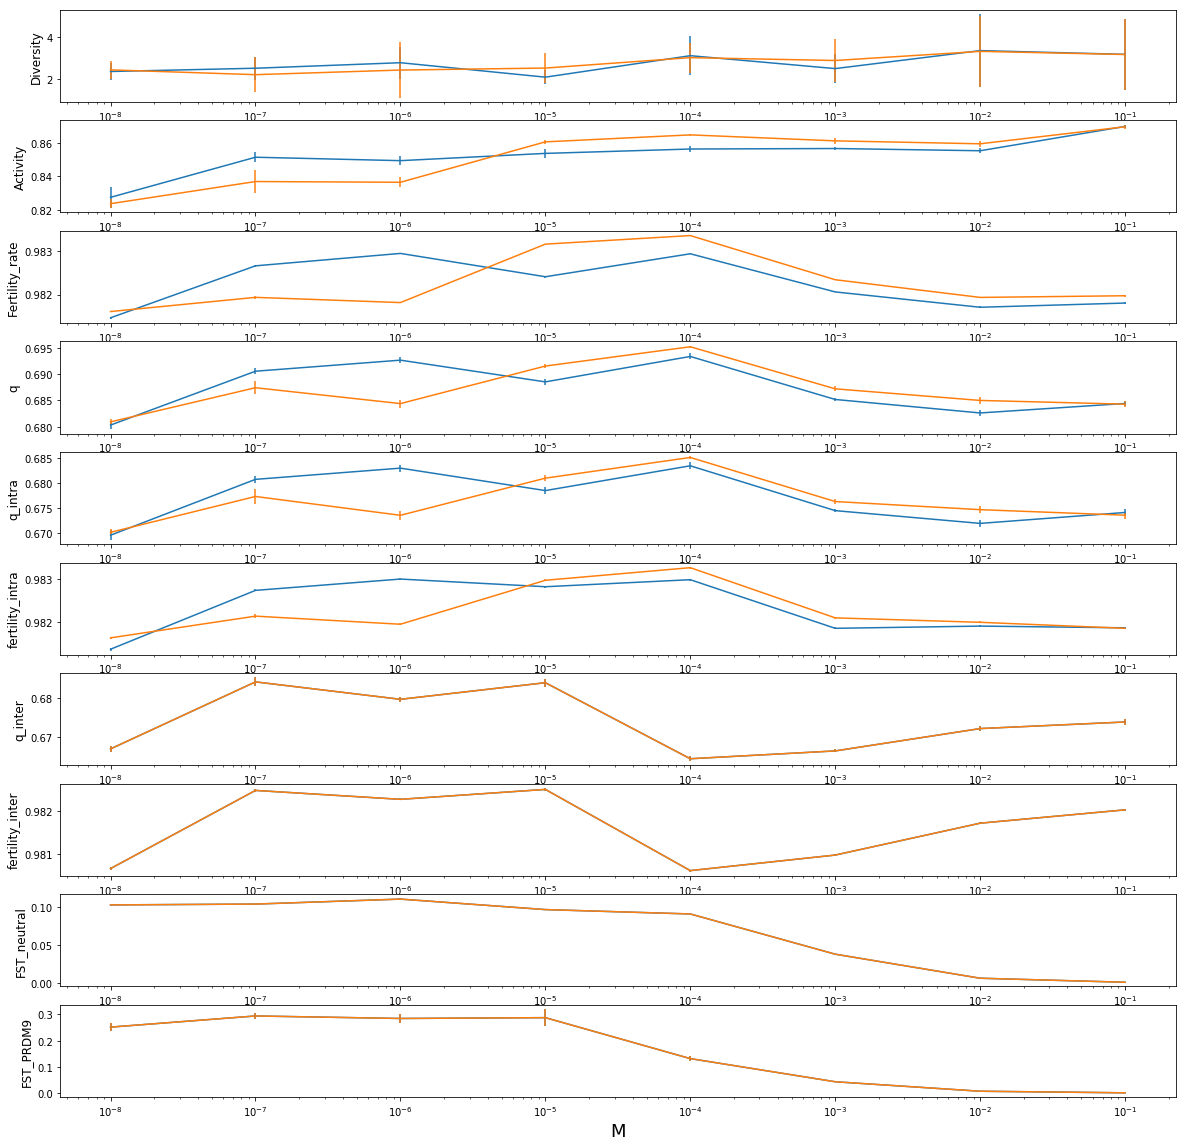

In [277]:
allele,allele1,allele2,trace,trace1,trace2=readscalingexperimentmigration(target_folder_path="analyses/scaling_M_3/" , scaling_param_name="M", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele"], param_names_trace=["Generation_number","Number_of_allele","Total_nb_allele","Total_number_of_allele","Diversity","Activity","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra","q_inter","fertility_inter","FST_neutral","FST_PRDM9"])
scaling_param_name="M"
param_to_plot=["Diversity","Activity","Fertility_rate","q","q_intra","fertility_intra","q_inter","fertility_inter","FST_neutral","FST_PRDM9"]
n=len(param_to_plot)

plt.figure(1, figsize=(20,20))
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    #if param_to_plot[index_parameter] in trace:
        #plt.errorbar(trace[scaling_param_name], trace[param_to_plot[index_parameter]+'_mean'], trace[param_to_plot[index_parameter]+'_variance'])
    plt.errorbar(trace1[scaling_param_name][1:len(trace1[scaling_param_name])], trace1[param_to_plot[index_parameter]+'_mean'][1:len(trace1[scaling_param_name])], trace1[param_to_plot[index_parameter]+'_variance'][1:len(trace1[scaling_param_name])])
    plt.errorbar(trace2[scaling_param_name][1:len(trace2[scaling_param_name])], trace2[param_to_plot[index_parameter]+'_mean'][1:len(trace2[scaling_param_name])], trace2[param_to_plot[index_parameter]+'_variance'][1:len(trace2[scaling_param_name])])
    plt.xscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

In [278]:
selct_coeff=[]
selct_coeff1=[]
selct_coeff2=[]
fourNs=[]
fourNs1=[]
fourNs2=[]
for index in range(len(trace1["Fertility_rate"+'_mean'])):
    selct_coeff1.append(intercept_list_pop_1[index]-trace1["Fertility_rate"+'_mean'][index])
    fourNs1.append(4*1000*selct_coeff1[index])
    selct_coeff2.append(intercept_list_pop_2[index]-trace2["Fertility_rate"+'_mean'][index])
    fourNs2.append(4*1000*selct_coeff2[index])
#print(selct_coeff1)
#print(selct_coeff2)
print(fourNs1)
print(fourNs2)

[26.405382670925182, 20.740238349376661, 22.565766635694651, 21.950899851841399, 17.179335702302012, 20.597390455334708, 17.344059376295018, 19.613400405977366, 23.885716902076748]
[32.138070808987784, 22.363110377855211, 22.480725540463098, 19.798581069836896, 17.298784625269015, 19.398993310557611, 26.027673662373463, 24.565646824389553, 26.413538736978381]


Text(0.5,0,'M')

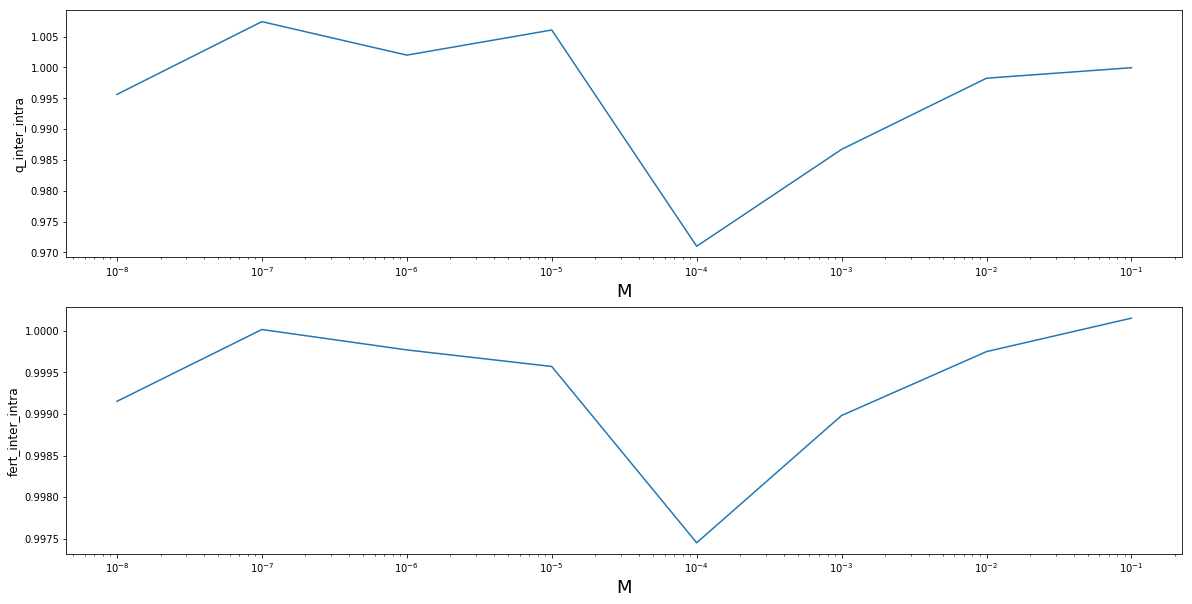

In [281]:
q_inter_intra=[]
fert_inter_intra=[]
for i in range(len(trace1["q_inter"+'_mean'])):
    if i != 0:
        q_inter_intra.append(trace1["q_inter"+'_mean'][i]/((trace1["q_intra"+'_mean'][i]+trace2["q_intra"+'_mean'][i])/2))
        fert_inter_intra.append(trace1["fertility_inter"+'_mean'][i]/((trace1["fertility_intra"+'_mean'][i]+trace2["fertility_intra"+'_mean'][i])/2))
plt.figure(1, figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(trace1["M"][1:len(trace1["q_inter"+'_mean'])],q_inter_intra)
plt.xscale('log')
plt.ylabel("q_inter_intra", fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 18)
plt.subplot(2,1,2)
plt.plot(trace1["M"][1:len(trace1["q_inter"+'_mean'])],fert_inter_intra)
plt.xscale('log')
plt.ylabel("fert_inter_intra", fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 18)